## Generalised Simulation Prototyping

In this notebook we aim to demonstrate the use of an override class to implement a treatment scenario which is dependent upon which block the node belongs to.

Here is the scenario; An SIS epidemic is at the endemic equilibrium.


It is spreading across dynamic/temporal network of fixed population size (no-one joins the network and no-one leaves). There are several block of densely connected nodes in the network, and nodes move between these blocks at a slow but constant rate. There are sparse connections between blocks.

At a certain time point, a treatment process begins in a block, say block 0.

If an infected node moves into block 0, it begins treatment with probability $p$. If the node remains in block 0 for the length of the treatment, then it moves into the susceptible state. The length of the treatment time is very short when compared to how long it would take the infection to run it's course.

We are interested in how the parameter $p$ affected the endemic equilbrium.

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
from SellkeSimulation.DynamicNetworks import dynamic_stochastic_block_model
from SellkeSimulation.Simulation import complex_epidemic_simulation

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

We begin by configuring a dynamic stochastic block model class with the following features.

* There are 4 blocks
* The probability of an edge forming between members of the same block is 0.5
* The probability of an edge forming between members of different blocks is 0.05
* At time 0, each block has 50 members, so each node is expected to have a degree of 32.5
* Nodes remain in a block for an exponentially distributed amount of time (mean = 30), after this time is up, they migrate to another block choosing uniformly at random.

We now define $p$ the matrix which stores the edge forming probabilties, $m$ the matrix which stores the migration probabilities.

In [3]:
p = [[0.5, 0.05, 0.05, 0.05], [0.05, 0.5, 0.05, 0.05], [0.05, 0.05, 0.5, 0.05], [0.05, 0.05, 0.05, 0.5]]
m = [[0, 1/3, 1/3, 1/3], [1/3, 0, 1/3, 1/3], [1/3, 1/3, 0, 1/3], [1/3, 1/3, 1/3, 0]]
sizes = [50,50,50,50]

my_network_model = dynamic_stochastic_block_model(sizes, p, m, waiting_time_par= 30, end_time = 1000)

Later on we will need to modify this so we can get our special treatment behaviour, but that will be further down the line. For now, lets see what it looks like.

In [4]:
colors= ["yellow" for _ in range(50)]
[colors.append("black") for _ in range(50)]
[colors.append("red") for _ in range(50)]
[colors.append("green") for _ in range(50)];

C:\Users\mfyles\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


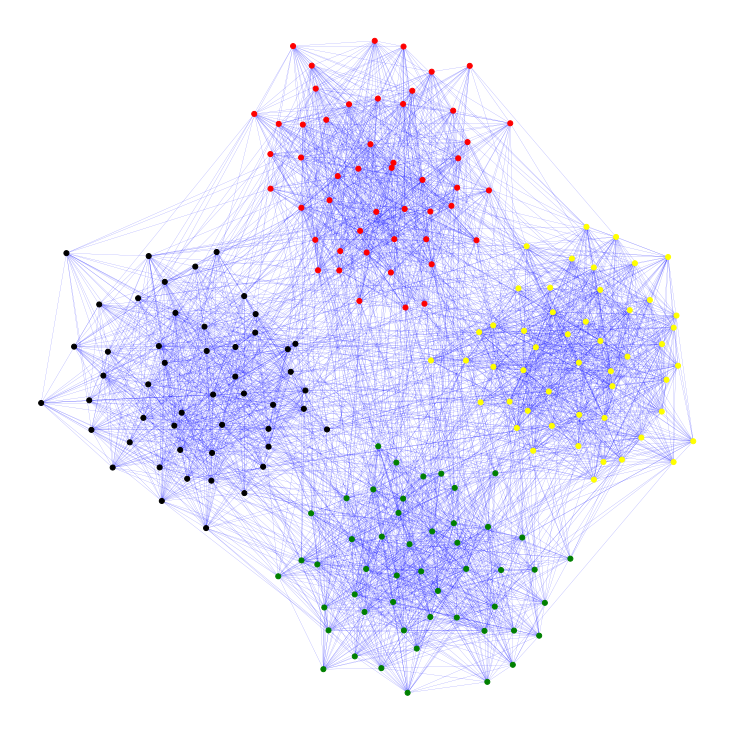

In [5]:
G=my_network_model.G
pos=nx.spring_layout(G)


plt.rcParams['figure.figsize'] = [10, 10]
nx.draw(G,pos,edge_color="blue",width=0.1, node_size = 25, node_color = colors, edge_cmap=plt.cm.Blues)
plt.show() # display

Notice that nodes 1 to 50 are all in the same block, likewise for nodes 51-100 and so on.

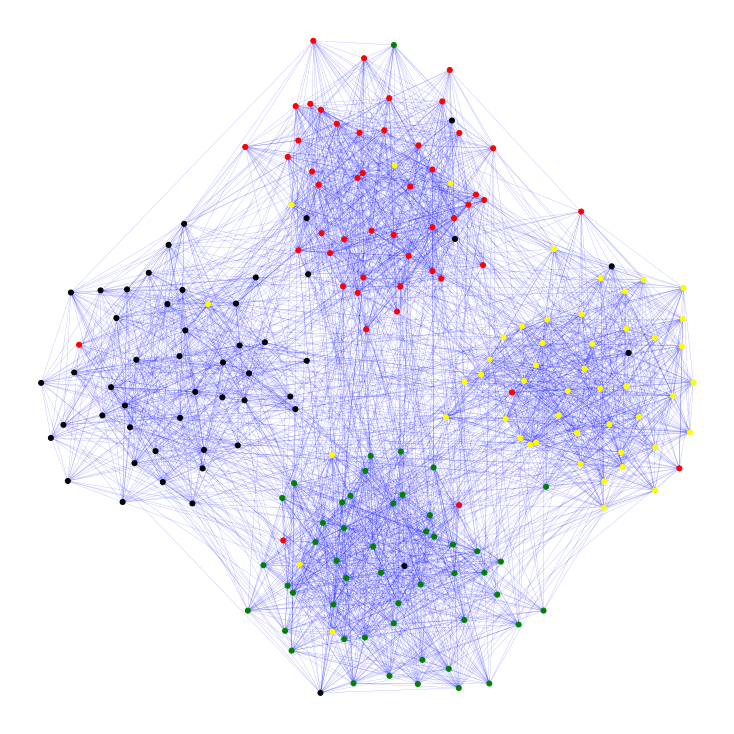

In [6]:
my_network_model.increment_network(5) #This increments the network by 5 units of time.

G=my_network_model.G
pos=nx.spring_layout(G, pos = pos)

plt.rcParams['figure.figsize'] = [10, 10]
nx.draw(G,pos,edge_color="blue",width=0.1, node_size = 25, node_color = colors,edge_cmap=plt.cm.Blues)
plt.show() # display

This is what the network looks like after 5 units of time. Some nodes have moved, but they all largely remain the same.

We now set up an infection to run on this network. To begin, we will only have SIS behaviour, and no treatment block.

In [11]:
my_network_model = dynamic_stochastic_block_model(sizes, p, m, waiting_time_par= 10, end_time = 1500)
my_network_epidemic = complex_epidemic_simulation(my_network_model.G,        # The network we defined earlier
                                                  beta = 0.005,             # Nodes emit hazard at a rate of 0.05 per day (constant rate, but can be changed)
                                                  I_parameters = 15,       # The length of an infection is distributed exponential(15)
                                                  initial_infected = 100,  # 100 nodes are initially infected at time = 0
                                                  time_increment = 0.5,    # Time is incremented in half a unit of time
                                                  max_iterations = 3000,   # 3000 increments are performed, so time = 1500 at the end.
                                                  SIS = True)              # The epidemic is of type SIS

my_network_epidemic.iterate_epidemic() # This is the command to perform the simulation, it's not ideal but it works for now.

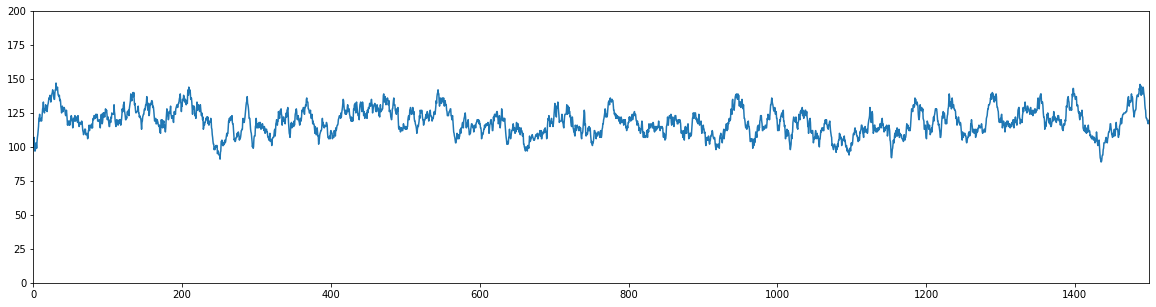

In [12]:
plt.rcParams['figure.figsize'] = [20, 5]

plt.ylim((0,200))
plt.xlim((0,1500))
plt.plot(my_network_epidemic.data_time, my_network_epidemic.data_infected_counts)

Now, as discussed we want to add in the custom behaviour, namely the treatment process in group 0.

To begin, we need to add a custom behaviour that lets us know when a node has moved into the treatment group. This is so that the epidemic simulation can see this, and start doing it's own custom behaviour.

In [13]:
def migration_flag(self, node):
    
    if self.G.nodes[node]["block"] == 0:
        self.G.nodes[node].update({"Migrated Into Treatment Group": "Yes"})
    #This should be done using a generic node_update method, but I haven't made one (yet)
    
#On the iteration that a node moves into the treatment group, it's flag is set to Yes.
#This means that another custom behaviour in the epidemic simulation layer can see the flag and act on it.

In [14]:
my_network_model = dynamic_stochastic_block_model(sizes, p, m, waiting_time_par= 10, end_time = 1000,
                                                  custom_attribute = {"Migrated Into Treatment Group": "No"},
                                                  custom_migration_behaviour = migration_flag
                                                 )

In [15]:
#The nodes which have just migrated into the treatment group.
my_network_model.increment_network(0.5) #Increment time in the network by 1
my_network_model.time
[node for node in my_network_model.G.nodes() if my_network_model.G.nodes[node]["Migrated Into Treatment Group"] == "Yes"] #See which were migrated into

[34]

In [16]:
def instant_treatment(self):
        
    #We look for nodes that have just migrated into the treatment group
    for node in self.dynamic_network.G.nodes():
            
        if self.dynamic_network.G.nodes[node]["Migrated Into Treatment Group"] == "Yes" and self.epi_data[node]["Infection Stage"] == "Infected" and self.time > 500:
            if npr.binomial(1, treatment_prob) == 1:
                self.data_structure.update_infection_stage([node], new_stage = "Susceptible", timepoint = self.time)
        self.dynamic_network.G.nodes[node].update({"Migrated Into Treatment Group": "No"})

In [17]:
treatment_prob = 0.9

my_dynamic_sbm = dynamic_stochastic_block_model(sizes, p, m, waiting_time_par= 15, end_time = 1500,
                                                  custom_attribute = {"Migrated Into Treatment Group": "No"},
                                                  custom_migration_behaviour = migration_flag
                                                 )

my_network_epidemic = complex_epidemic_simulation(my_dynamic_sbm.G,        # The network we defined earlier
                                                 beta = 0.005,            # Nodes emit hazard at a rate of 0.05 per day (constant rate, but can be changed)
                                                 I_parameters = 15,       # The length of an infection is distributed exponential(15)
                                                 initial_infected = 100,  # 100 nodes are initially infected at time = 0
                                                 time_increment = 0.5,    # Time is incremented in half a unit of time
                                                 max_iterations = 3000,   # 2000 increments are performed, so time = 1000 at the end.
                                                 SIS = True,              # The epidemic is of type SIS
                                                 custom_behaviour = instant_treatment,
                                                 increment_network = my_dynamic_sbm.increment_network,
                                                 dynamic_network = my_dynamic_sbm) # We ask it to call our custom behaviour

In [18]:
my_network_epidemic.iterate_epidemic()

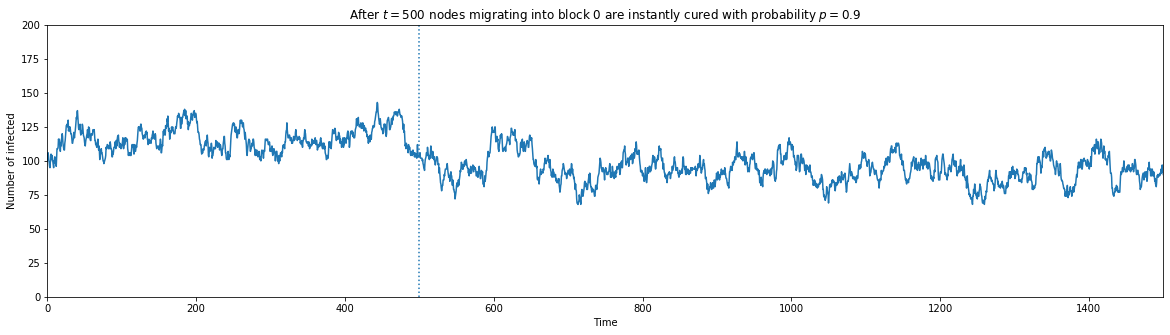

In [19]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.xlim((0,1500))
plt.ylim((0,200))
plt.xlabel("Time")
plt.ylabel("Number of infected")
plt.title("After $t=500$ nodes migrating into block 0 are instantly cured with probability $p = 0.9$")
plt.axvline(x=500, linestyle= ":")
plt.plot(my_network_epidemic.data_time, my_network_epidemic.data_infected_counts)

In [20]:
number_of_steps = 4
repeats = 10
results = np.zeros(shape = (number_of_steps,repeats,3001))
parameters = []
                    

for increment in range(number_of_steps):
    
    treatment_prob = 0.3*increment
    parameters.append(treatment_prob)
    np.random.seed(increment)
    
    for i in range(repeats):

        my_dynamic_sbm = dynamic_stochastic_block_model(sizes, p, m, waiting_time_par= 15, end_time = 1500,
                                                  custom_attribute = {"Migrated Into Treatment Group": "No"},
                                                  custom_migration_behaviour = migration_flag
                                                 )
        
        my_network_epidemic = complex_epidemic_simulation(my_dynamic_sbm.G,        # The network we defined earlier
                                                         beta = 0.005,            # Nodes emit hazard at a rate of 0.05 per day (constant rate, but can be changed)
                                                         I_parameters = 15,       # The length of an infection is distributed exponential(15)
                                                         initial_infected = 100,  # 100 nodes are initially infected at time = 0
                                                         time_increment = 0.5,    # Time is incremented in half a unit of time
                                                         max_iterations = 3000,   # 2000 increments are performed, so time = 1000 at the end.
                                                         SIS = True,              # The epidemic is of type SIS
                                                         custom_behaviour = instant_treatment,
                                                         increment_network = my_dynamic_sbm.increment_network,
                                                         dynamic_network = my_dynamic_sbm) # We ask it to call our custom behaviour
    
        my_network_epidemic.iterate_epidemic()
        
        time = my_network_epidemic.data_time
        
        infected_counts = my_network_epidemic.data_infected_counts 
        
        while len(my_network_epidemic.data_infected_counts) < 3001:
            infected_counts.append(0)
        
        results[increment, i] = results[increment, i] + infected_counts
        sys.stdout.flush()
        print('Round: ', increment, '    Percentage Complete: ', round(i/repeats*100), '%' , end='\r')

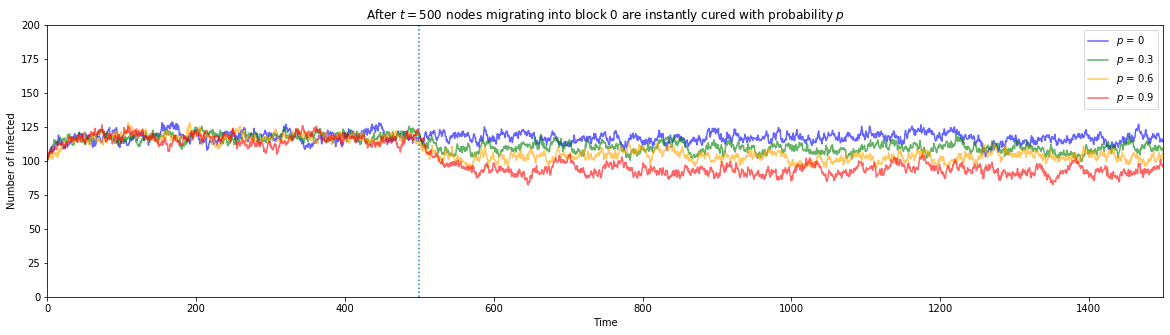

In [21]:
median = np.zeros(shape = (number_of_steps, 3001))
for model in range(number_of_steps):
    for i in range(3001):
        median[model, i] = median[model, i] + np.median(results[model, :, i])

plt.rcParams['figure.figsize'] = [20, 5]        
        
plt.title("After $t=500$ nodes migrating into block 0 are instantly cured with probability $p$")
plt.ylim((0,200))
plt.xlim((0,1500))
plt.xlabel("Time")
plt.ylabel("Number of Infected")

time = []
for i in range(3001):
    time.append(i*0.5)
    
color_range = ["blue", "green", "orange", "red"] 

for model in range(number_of_steps):
    plt.plot(time, median[model, :], color = color_range[model], alpha = 0.6)

plt.legend(["$p$ = 0","$p$ = 0.3","$p$ = 0.6","$p$ = 0.9"])

plt.axvline(x=500, linestyle= ":")